# object selection form catalog

currently it's just a simple selection S/N of Ha Hb fluxes > 5

# THis section of the code separately combines photometry, spectroscopy, Lmass, morphology & AGN catalog together, separately for GN GS fields.

total number of objects: 6048
fraction of bad mass: 0.005291005291005291
fraction of bad re: 0.11888227513227513
fraction of bad z: 0.01025132275132275
fraction of bad values before bad ha hb: 0.12962962962962962
fraction of bad ha: 0.4093915343915344
fraction of bad hb: 0.6013558201058201


/var/folders/6h/pm731bh5769gqlt1mrys7wth0000gn/T/ipykernel_22105/777123099.py:210: UserWarning: You passed a edgecolor/edgecolors ('orange') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(
/var/folders/6h/pm731bh5769gqlt1mrys7wth0000gn/T/ipykernel_22105/777123099.py:227: UserWarning: You passed a edgecolor/edgecolors ('orange') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(


57 AGN found in total 1442 objects
fraction of agn in full catalog: 0.03952843273231623


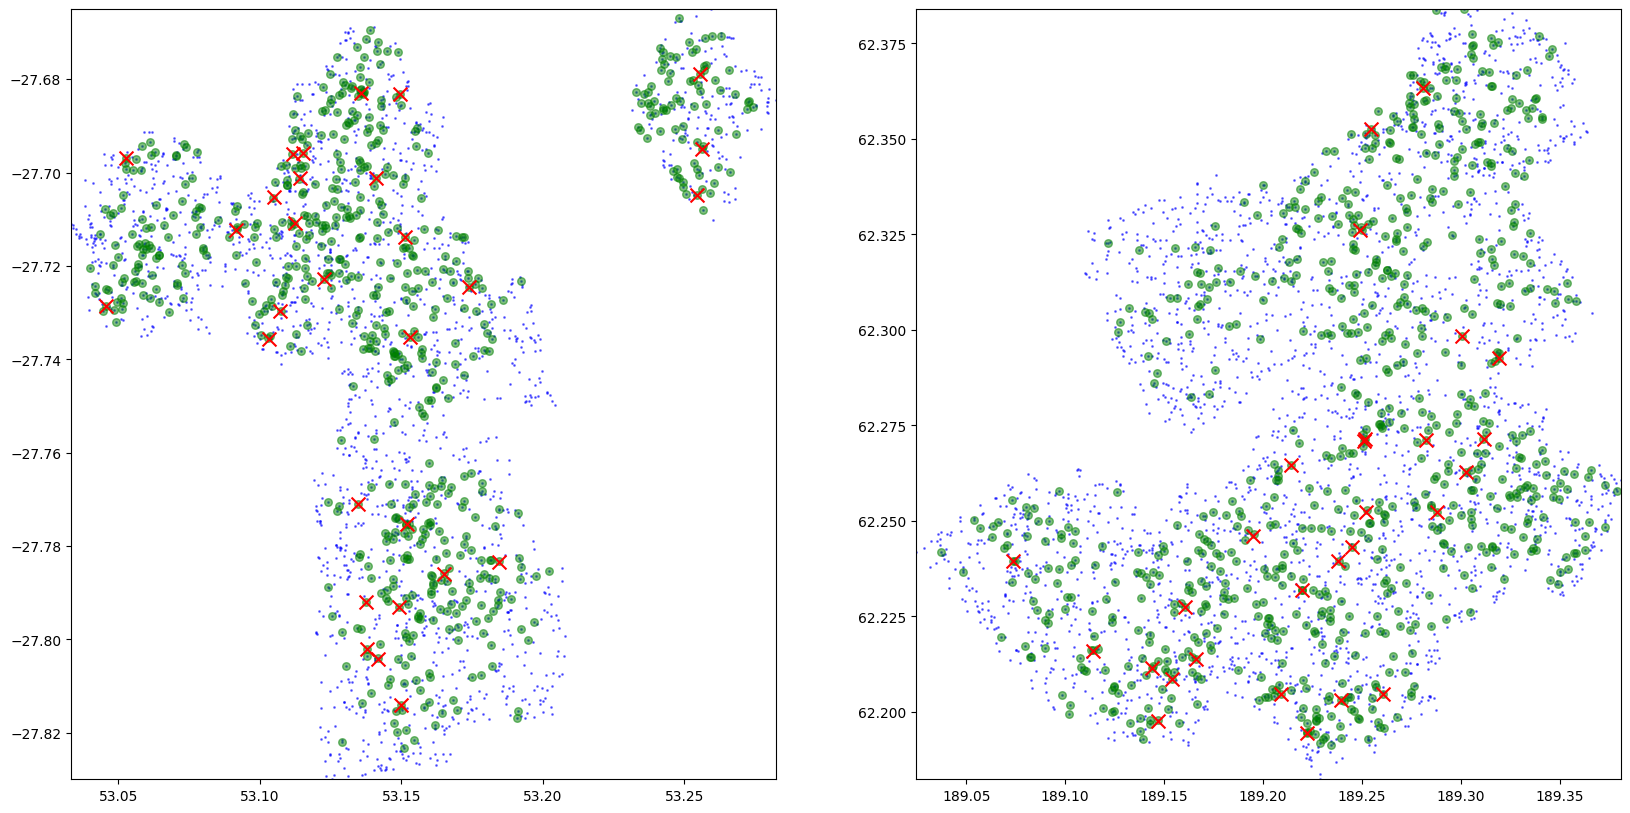

In [ ]:
from   astropy.table        import Table, vstack, join, setdiff
from   scripts.tools        import *
import numpy                as     np
from   astropy.coordinates  import SkyCoord, match_coordinates_sky
import astropy.units        as     u
from   astropy.cosmology    import Planck18
import pandas               as     pd
# visualize id crossmatch
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

import warnings
from   astropy.io.fits.card import VerifyWarning
warnings.simplefilter('ignore', VerifyWarning)


### CLEAR GoodsN+S sample prearation, stacking
# initial catalog
gn   = Table.read('hlsp_clear_hst_wfc3_gdn_multi_v4.1_clear.fits')
gn_m = Table.read('hlsp_clear_hst_wfc3-acs_gdn-3dhst_multi_v4.6_zout.fits')
gn_gal = Table.read('galfit/goodsn/goodsn_3dhst.v4.1_f125w.galfit',format='ascii')
gn_all = join(gn_m,gn_gal,keys_left='id',keys_right='NUMBER',join_type='left')
gn_cat = join(gn,gn_all,keys_left='ID',keys_right='id',join_type='left',metadata_conflicts='silent')
gn_cat['field'] = 'gn'



gs   = Table.read('hlsp_clear_hst_wfc3_gds_multi_v4.1_clear.fits')
gs_m = Table.read('hlsp_clear_hst_wfc3-acs_gds-3dhst_multi_v4.6_zout.fits')
gs_gal = Table.read('galfit/goodss/goodss_3dhst.v4.1_f125w.galfit',format='ascii')
gs_all = join(gs_m,gs_gal,keys_left='id',keys_right='NUMBER',join_type='left')
gs_cat = join(gs,gs_all,keys_left='ID',keys_right='id',join_type='left',metadata_conflicts='silent')
gs_cat['field'] = 'gs'

cat_lis = vstack([gn_cat,gs_cat],metadata_conflicts='silent')

cat_lis.write('master_cat.fits',overwrite=True)

#constrain positive redshift
z_real = cat_lis['z_MAP'] > 0
#constrain positive mass
mass_real = cat_lis['mass'] > 0
#constrain positive re
re_real = cat_lis['f'] <=  1
#constrain positie ha and hb
ha_real = cat_lis['Ha_FLUX'] > 0
hb_real = cat_lis['Hb_FLUX'] > 0

#calculate sn ratio
sn_ha = cat_lis['Ha_FLUX']/cat_lis['Ha_FLUX_ERR']
cat_lis['sn_ha'] = sn_ha
sn_hb = cat_lis['Hb_FLUX']/cat_lis['Hb_FLUX_ERR']
cat_lis['sn_hb'] = sn_hb

print('total number of objects:', len(cat_lis))
print('fraction of bad mass:', len(cat_lis[cat_lis['mass'] <= 0]) / len(cat_lis))
print('fraction of bad re:', len(cat_lis[cat_lis['f'] > 1]) / len(cat_lis))
print('fraction of bad z:', len(cat_lis[cat_lis['z_MAP'] <= 0]) / len(cat_lis))
print('fraction of bad values before bad ha hb:', len(cat_lis[~(z_real & mass_real & re_real)]) / len(cat_lis))
print('fraction of bad ha:', len(cat_lis[cat_lis['Ha_FLUX'] <= 0]) / len(cat_lis))
print('fraction of bad hb:', len(cat_lis[cat_lis['Hb_FLUX'] <= 0]) / len(cat_lis))

cat_lis = cat_lis[z_real & mass_real & re_real & ha_real & hb_real]

#positive crossmatch_threshold in arcsec
thresh =  2
#make 2 subplots
plt.figure(figsize=(20, 10))
### Chandra catalog preparation and cross match
#goodss xray catalog
column_specs_gs = [
    (0, 4), (5, 14), (15, 25), (26, 31), (32, 34), (35, 39), (40, 45), 
    (46, 53), (54, 59), (60, 65), (66, 73), (74, 79), (80, 85), (86, 93), 
    (94, 99), (100, 105), (106, 107), (108, 115), (116, 121), (122, 145), 
    (146, 155), (156, 166), (167, 172), (173, 182), (183, 193), (194, 199), 
    (200, 209), (210, 220), (221, 226), (227, 236), (237, 247), (248, 253), 
    (254, 263), (264, 274), (275, 280), (281, 290), (291, 301), (302, 307), 
    (308, 317), (318, 328), (329, 334), (335, 341), (342, 350), (351, 353), 
    (354, 359), (360, 365), (366, 371), (372, 377), (378, 383), (384, 389), 
    (390, 396), (397, 402), (403, 408), (409, 414), (415, 423), (424, 432), 
    (433, 441), (442, 448), (449, 455), (456, 462), (463, 468), (469, 474), 
    (475, 480), (481, 490), (491, 500), (501, 510), (511, 520), (521, 530), 
    (531, 540), (541, 547), (548, 551), (552, 555), (556, 560)
]
column_names_gs = [
    "XID", "RAdeg", "DEdeg", "logPB", "WAV", "PE", "Angle", "FB", "e_FB", "E_FB",
    "SB", "e_SB", "E_SB", "HB", "e_HB", "E_HB", "PNOTE", "CPCAT", "CPDIS", "CPNOTE",
    "WFI-RA", "WFI-DE", "WFImag", "GOODSS-RA", "GOODSS-DE", "GOODSSmag", 
    "GEMS-RA", "GEMS-DE", "GEMSmag", "CANDELS-RA", "CANDELS-DE", "CANDELSmag",
    "TENIS-RA", "TENIS-DE", "TENISmag", "SEDS-RA", "SEDS-DE", "SEDSmag",
    "VLA-RA", "VLA-DE", "VLAmag", "zSpec", "q_zSpec", "r_zSpec", "zL10", "zR11", 
    "zH14", "zS14", "zS15", "zS16", "zF", "r_zF", "e_zF", "E_zF", "FExp", "SExp", 
    "HExp", "BR", "e_BR", "E_BR", "Gamma", "e_Gamma", "E_Gamma", "FFB", "FSB",
    "FHB", "LX", "NH", "LXc", "OType", "X11ID", "X16ID", "R13ID"
]

chandra_gs = Table.from_pandas(
                pd.read_fwf('chandra_gs.txt', 
                            colspecs=column_specs_gs,  
                            names=column_names_gs,     
                            skiprows=174))

#goodsn xray catalog
column_specs_gn = [
    (0, 3), (4, 6), (7, 9), (10, 15), (16, 17), (17, 19), (20, 22), (23, 27),
    (28, 33), (34, 36), (37, 40), (41, 46), (47, 55), (56, 62), (63, 69), (70, 78),
    (79, 85), (86, 92), (93, 101), (102, 108), (109, 115), (116, 117), (118, 120),
    (121, 123), (124, 129), (130, 131), (131, 133), (134, 136), (137, 141), (142, 147),
    (148, 153), (154, 161), (162, 164), (165, 167), (168, 173), (174, 175), (175, 177),
    (178, 180), (181, 185), (186, 191), (192, 194), (195, 197), (198, 203), (204, 205),
    (205, 207), (208, 210), (211, 215), (216, 221), (222, 224), (225, 227), (228, 233),
    (234, 235), (235, 237), (238, 240), (241, 245), (246, 251), (252, 254), (255, 257),
    (258, 263), (264, 265), (265, 267), (268, 270), (271, 275), (276, 281), (282, 284),
    (285, 287), (288, 293), (294, 295), (295, 297), (298, 300), (301, 305), (306, 311),
    (312, 314), (315, 317), (318, 323), (324, 325), (325, 327), (328, 330), (331, 335),
    (336, 341), (342, 348), (349, 351), (352, 358), (359, 365), (366, 372), (373, 379),
    (380, 386), (387, 395), (396, 402), (403, 409), (410, 416), (417, 423), (424, 430),
    (431, 437), (438, 444), (445, 447), (448, 450), (451, 456), (457, 458), (458, 460),
    (461, 463), (464, 468), (469, 478), (479, 488), (489, 498), (499, 504), (505, 510),
    (511, 516), (517, 522), (523, 528), (529, 534), (535, 544), (545, 554), (555, 564),
    (565, 574), (575, 581), (582, 585)
]
column_names_gn = [
    "ID", "RAh", "RAm", "RAs", "DE-", "DEd", "DEm", "DEs", "Log(P)", "Log(Pm)",
    "PosErr", "OffAng", "FCts", "UFCts", "LFCts", "SCts", "USCts", "LSCts", "HCts",
    "UHCts", "LHCts", "Ifpsf", "CRAh", "CRAm", "CRAs", "CDE-", "CDEd", "CDEm",
    "CDEs", "C-XOff", "Cmag", "Ccat", "VRAh", "VRAm", "VRAs", "VDE-", "VDEd",
    "VDEm", "VDEs", "Vmag", "GDRAh", "GDRAm", "GDRAs", "GDDE-", "GDDEd", "GDDEm",
    "GDDEs", "GDmag", "CFRAh", "CFRAm", "CFRAs", "CFDE-", "CFDEd", "CFDEm", "CFDEs",
    "CFmag", "KsRAh", "KsRAm", "KsRAs", "KsDE-", "KsDEd", "KsDEm", "KsDEs", "Ksmag",
    "RRAh", "RRAm", "RRAs", "RDE-", "RDEd", "RDEm", "RDEs", "Rmag", "SRAh", "SRAm",
    "SRAs", "SDE-", "SDEd", "SDEm", "SDEs", "Smag", "zspec", "zref", "zphoty",
    "zphotyl", "zphotyu", "q_zphoty", "zphotya", "f_zphoty", "zphots", "zphotsl",
    "zphotsu", "q_zphots", "f_zphots", "zadopt", "A03", "A03RAh", "A03RAm", "A03RAs",
    "A03DE-", "A03DEd", "A03DEm", "A03DEs", "FExp", "SExp", "HExp", "BRat", "UBRat",
    "LBRat", "PInd", "UPInd", "LPInd", "FFlux", "SFlux", "HFlux", "Lx", "Type", "Notes"
]

chandra_gn = Table.from_pandas(
                pd.read_fwf('chandra_gn.txt', 
                            colspecs=column_specs_gn,  
                            names=column_names_gn,     
                            skiprows=217))


#here convert ra dec coordinates to degree
if True:
    
    # Extract RA and DEC columns from the Astropy table
    ra_h = chandra_gn['CFRAh']  # Hour of Right Ascension
    ra_m = chandra_gn['CFRAm']  # Minute of Right Ascension
    ra_s = chandra_gn['CFRAs']  # Second of Right Ascension
    dec_sign = chandra_gn['CFDE-']  # Sign of Declination
    dec_d = chandra_gn['CFDEd']  # Degree of Declination
    dec_m = chandra_gn['CFDEm']  # Arcminute of Declination
    dec_s = chandra_gn['CFDEs']  # Arcsecond of Declination
    '''
    #try anothere ra dec
    ra_h = chandra_gn['RAh']  # Hour of Right Ascension
    ra_m = chandra_gn['RAm']  # Minute of Right Ascension
    ra_s = chandra_gn['RAs']  # Second of Right Ascension
    dec_sign = chandra_gn['DE-']  # Sign of Declination
    dec_d = chandra_gn['DEd']  # Degree of Declination
    dec_m = chandra_gn['DEm']  # Arcminute of Declination
    dec_s = chandra_gn['DEs']  # Arcsecond of Declination
    '''

    # Convert RA to degrees using scipy vectorization
    ra_deg = 15 * (np.add(ra_h, np.add(ra_m / 60, ra_s / 3600)))  # Convert RA to degrees (1 hour = 15 degrees)
    # Convert DEC to degrees based on the sign using scipy functions
    dec_deg = np.add(dec_d, np.add(dec_m / 60, dec_s / 3600))  # Convert Declination to degrees
    dec_deg = np.where(dec_sign == '-', -dec_deg, dec_deg)  # Apply the sign to Declination

    # Add converted RA and DEC in degrees to the table
    chandra_gn['RAdeg'] = ra_deg  # Right Ascension in degrees
    chandra_gn['DEdeg'] = dec_deg  # Declination in degrees


#now cross match xray catalog
coord_obj  = SkyCoord(cat_lis['ra'],cat_lis['dec'],unit=(u.deg,u.deg))
#
#goodss agn crossmatch
agn_gs      = chandra_gs[chandra_gs['OType']=='AGN']
coord_chan_gs = SkyCoord(
                        agn_gs['RAdeg'],
                        agn_gs['DEdeg'],
                        unit=(u.deg, u.deg))
idx_gs,d2d_gs,d3d_gs = match_coordinates_sky(coord_chan_gs,coord_obj)

#goodsn agn catalog
agn_gn      = chandra_gn[chandra_gn['Type']=='AGN']
#agn_mask_gn = chandra_gn['Type'] != 'ddf'
coord_chan_gn = SkyCoord(
                        agn_gn['RAdeg'],
                        agn_gn['DEdeg'],
                        unit=(u.deg, u.deg))
idx_gn,d2d_gn,d3d_gn = match_coordinates_sky(coord_chan_gn,coord_obj)

# --- Visualization of cross-matching results ---

# Make first subplot: GOODS-South
plt.subplot(121)
# Plot all GOODS-South sources (blue, small)
plt.scatter(gs_cat['ra'], gs_cat['dec'], s=1, alpha=0.5, color='blue', label='GOODS-South')
# Highlight sources in GOODS-South with positive Ha/Hb flux (green, larger)
gs_mask = cat_lis['field'] == 'gs'
plt.scatter(cat_lis['ra'][gs_mask], cat_lis['dec'][gs_mask], s=30, alpha=0.5, color='green', label='Ha/Hb flux > 0')
# Plot cross-matched Chandra AGN (red 'x')
plt.scatter(
    agn_gs['RAdeg'][d2d_gs.arcsec < thresh],
    agn_gs['DEdeg'][d2d_gs.arcsec < thresh],
    s=100, alpha=1, color='red', label='GOODS-South Chandra catalog',
    marker='x', edgecolor='orange'
)
plt.xlim(np.min(gs_cat['ra']), np.max(gs_cat['ra']))
plt.ylim(np.min(gs_cat['dec']), np.max(gs_cat['dec']))

# Make second subplot: GOODS-North
plt.subplot(122)
# Plot all GOODS-North sources (blue, small)
plt.scatter(gn_cat['ra'], gn_cat['dec'], s=1, alpha=0.5, color='blue', label='GOODS-North')
# Highlight sources in GOODS-North with positive Ha/Hb flux (green, larger)
gn_mask = cat_lis['field'] == 'gn'
plt.scatter(cat_lis['ra'][gn_mask], cat_lis['dec'][gn_mask], s=30, alpha=0.5, color='green', label='Ha/Hb flux > 0')
# Plot cross-matched Chandra AGN (red 'x', orange edge)
plt.scatter(
    agn_gn['RAdeg'][d2d_gn.arcsec < thresh],
    agn_gn['DEdeg'][d2d_gn.arcsec < thresh],
    s=100, alpha=1, color='red', label='GOODS-North Chandra catalog',
    marker='x', edgecolor='orange'
)
plt.xlim(np.min(gn_cat['ra']), np.max(gn_cat['ra']))
plt.ylim(np.min(gn_cat['dec']), np.max(gn_cat['dec']))

# --- Cross-matching and tagging ---

# Combine indices of all matched sources (within threshold) from both fields
id_matched = np.append(idx_gs[d2d_gs.arcsec < thresh], idx_gn[d2d_gn.arcsec < thresh])

# Tag sources as 'agn' if matched, otherwise 'gxy'
cat_lis['tag'] = ['agn' if index in id_matched else 'gxy' for index in range(len(cat_lis))]

# Save the full catalog with AGN tags
cat_lis.write('full_object_catalog.fits', overwrite=True)

# Print AGN fraction in the catalog
print(len(cat_lis[cat_lis['tag'] == 'agn']), 'AGN found in total', len(cat_lis), 'objects')
print('fraction of agn in full catalog:', len(cat_lis[cat_lis['tag'] == 'agn']) / len(cat_lis))



### s/n and manual selection

num of objs after s/n>0 selection: 553
num of obj after agn selection 520


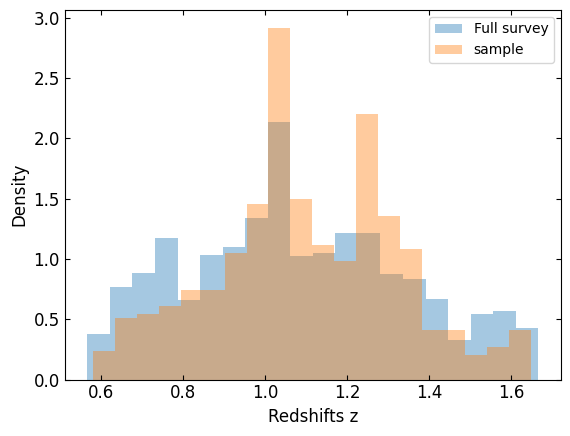

In [ ]:
cat_hasline = cat_lis[np.logical_and(cat_lis['Ha_FLUX'] >0, cat_lis['Hb_FLUX']>0)]
sn_ha = cat_hasline['Ha_FLUX']/cat_hasline['Ha_FLUX_ERR']
cat_hasline['sn_ha'] = sn_ha
sn_hb = cat_hasline['Hb_FLUX']/cat_hasline['Hb_FLUX_ERR']
cat_hasline['sn_hb'] = sn_hb

#sn hb and sn ha > 2
obj_lis = cat_hasline[np.logical_and(cat_hasline['sn_ha']>2, cat_hasline['sn_hb']>2)]

'''
manual_selection = np.array((
    ['ERSPRIME',40759],
    ['ERSPRIME',43823],
    ['ERSPRIME',45646],
    ['GN1',37031],
    ['GN1',37913],
    ['GN1',37395],
    ['GN1',37623],
    ['GN1',37738],
    ['GN1',38134],
    ['GN2', 11228],
    ['GN2', 14895],
    ['GN2', 14895],
    #['GN2', 16752],
    ['GN2', 17579],
    ['GN2', 17829],
    ['GN2', 18197],
    ['GN2', 18224],
    ['GN2', 18315],
    ['GN2', 21552],
    #['GN3', 28121],
    ['GN3', 30204],
    ['GN3', 32166],
    ['GN3', 32660],
    ['GN3', 34570],
    ['GN3', 34708],
    ['GN3', 34838],
    ['GN3', 35042],
    ['GN3', 35568],
    ['GN3', 35822],
    ['GN3', 19075],
    ['GN3', 28121],
    #['GN4', 21690],
    ['GN4', 24377],
    #['GN4', 24582],
    ['GN4', 26015],
    #['GN4', 28379],
    ['GN4', 27282],
    ['GN5', 31789],
    ['GN7', 12769],
    #['GN7', 13909],
    ['GN7', 13197],
    #['GN7', 13777],
    #['GN7', 14281],
    ['GN7', 14716],
    #['GN7', 14184],
    #['GN7', 14850],
    ['GN7', 15127],
    ['GN7', 15204],
    ['GN7', 15300],
    ['GN7', 17352],
    ['GN7', 17532],
    ['GN7', 22746],
    ['GN7', 19504],
    ['GN7', 23580],
    ['GS1', 45789],
    ['GS1', 47214],
    #['GS1', 47399],
    ['GS1', 47375],
    ['GS1', 48850],
    #['GS2', 48123],
    ['GS1', 49063],
    #['GS1', 36182],
    ['GS2', 45633],
    ['GS2', 46564],
    ['GS2', 47770],
    ['GS2', 45795],
    #['GS3', 37010],
    ['GS2', 48652],
    ['GS3', 34363],
    ['GS3', 37903],
    ['GS3', 40611],
    ['GS3', 41370],
    ['GS4', 20698],
    ['GS4', 24803],
    ['GS4', 25452],
    ['GS4', 24947],
    ['GS4', 25641],
    #['GS4', 25745],
    ['GS4', 25592],
    ['GS4', 26739],
    ['GS4', 29686],
    ['GS4', 20970],
    ['GS2', 46564],
    #['GS4', 22730],
    ['GS4', 26175],
    #['GS4', 26807],
    ['GS4', 29717],
    ['GS4', 29846],
    ['GS4', 29394],
    ['GS4', 28190],
    ['GS4', 30976],
    ['GS4', 31454],
    ['GS5', 38513],
    ['GS4', 20976],
    ['GS5', 41122],
    #['GS5', 44066],
    #['GS5', 40976],
    #['GS5', 44519],
    ['GS5', 42758],
    #['GS5', 42472],\
    ['GN2', 16867],
    ['GN7', 17024],
    ['GN7', 17190],
    ['GN2', 17194],
    ['GN7', 17216],
    ['GN2', 17204],
    ['GN2', 17139],
    ['ERSPRIME', 39689],
    ['GS3', 39619],
    ['GS3', 40042],
    ['GS5', 40306],
    ['GS3', 40334],
    ['GS5', 40811],
    ['GS5', 40774],
    ['GS3', 41261],
    ['ERSPRIME', 41688],
    ['GS5', 41923],
    ['ERSPRIME', 42139]
))
manual_selection = []
is_selected = np.isin(obj_lis['ID'],manual_selection[:,1]) & np.isin(obj_lis['subfield'],manual_selection[:,0])
obj_lis['manual_select'] = np.where(is_selected,'selected','keep') 
'''
obj_lis['pixel_length']  =  np.deg2rad(0.1/3600) * Planck18.angular_diameter_distance(obj_lis['z_MAP']).to(u.kpc).value

print('num of objects with ')

mask = (obj_lis['f'] <= 1) & (obj_lis['mass'] > 0) & (obj_lis['re'] > 0)
obj_lis = obj_lis[mask]


obj_lis.write('obj_lis_selected.fits',overwrite=True)

print('num of objs after s/n>0 selection:',len(obj_lis))
print('num of obj after agn selection',len(obj_lis[obj_lis['tag']!='agn']))


### redshift of selected objs
full_object_list = Table.read('full_object_catalog.fits')
obj_with_line = full_object_list[np.logical_and(full_object_list['Ha_FLUX']>0,full_object_list['Hb_FLUX']>0)]

plt.hist(obj_with_line['z_MAP'],bins=20,alpha=0.4,density=True,label='Full survey')
plt.hist(obj_lis['z_MAP'],bins=20,alpha=0.4,density=True,label='sample')
plt.xlabel('Redshifts z',fontsize=12)
plt.ylabel('Density',fontsize=12)
plt.tick_params(axis='both', which='major', labelsize=12, direction='in', top=True, right=True)
plt.legend()
plt.savefig('image_outputs/redshift_distribution.jpg',transparent=False)


In [5]:
obj_lis[0]

ID,RA_1,DEC_1,nlines,z_50,z_02,z_16,z_84,z_97,z_MAP,z_RISK,ArIII-7138_FLUX,ArIII-7138_FLUX_ERR,ArIII-7138_EW_RF_16,ArIII-7138_EW_RF_50,ArIII-7138_EW_RF_84,CIII-1908_FLUX,CIII-1908_FLUX_ERR,CIII-1908_EW_RF_16,CIII-1908_EW_RF_50,CIII-1908_EW_RF_84,CIV-1549_FLUX,CIV-1549_FLUX_ERR,CIV-1549_EW_RF_16,CIV-1549_EW_RF_50,CIV-1549_EW_RF_84,H8_FLUX,H8_FLUX_ERR,H8_EW_RF_16,H8_EW_RF_50,H8_EW_RF_84,H9_FLUX,H9_FLUX_ERR,H9_EW_RF_16,H9_EW_RF_50,H9_EW_RF_84,Ha_FLUX,Ha_FLUX_ERR,Ha_EW_RF_16,Ha_EW_RF_50,Ha_EW_RF_84,Hb_FLUX,Hb_FLUX_ERR,Hb_EW_RF_16,Hb_EW_RF_50,Hb_EW_RF_84,Hd_FLUX,Hd_FLUX_ERR,Hd_EW_RF_16,Hd_EW_RF_50,Hd_EW_RF_84,HeI-1083_FLUX,HeI-1083_FLUX_ERR,HeI-1083_EW_RF_16,HeI-1083_EW_RF_50,HeI-1083_EW_RF_84,HeI-5877_FLUX,HeI-5877_FLUX_ERR,HeI-5877_EW_RF_16,HeI-5877_EW_RF_50,HeI-5877_EW_RF_84,HeII-1640_FLUX,HeII-1640_FLUX_ERR,HeII-1640_EW_RF_16,HeII-1640_EW_RF_50,HeII-1640_EW_RF_84,Hg_FLUX,Hg_FLUX_ERR,Hg_EW_RF_16,Hg_EW_RF_50,Hg_EW_RF_84,Lya_FLUX,Lya_FLUX_ERR,Lya_EW_RF_16,Lya_EW_RF_50,Lya_EW_RF_84,MgII_FLUX,MgII_FLUX_ERR,MgII_EW_RF_16,MgII_EW_RF_50,MgII_EW_RF_84,NIII-1750_FLUX,NIII-1750_FLUX_ERR,NIII-1750_EW_RF_16,NIII-1750_EW_RF_50,NIII-1750_EW_RF_84,NIV-1487_FLUX,NIV-1487_FLUX_ERR,NIV-1487_EW_RF_16,NIV-1487_EW_RF_50,NIV-1487_EW_RF_84,NV-1240_FLUX,NV-1240_FLUX_ERR,NV-1240_EW_RF_16,NV-1240_EW_RF_50,NV-1240_EW_RF_84,NeIII-3867_FLUX,NeIII-3867_FLUX_ERR,NeIII-3867_EW_RF_16,NeIII-3867_EW_RF_50,NeIII-3867_EW_RF_84,NeV-3346_FLUX,NeV-3346_FLUX_ERR,NeV-3346_EW_RF_16,NeV-3346_EW_RF_50,NeV-3346_EW_RF_84,NeVI-3426_FLUX,NeVI-3426_FLUX_ERR,NeVI-3426_EW_RF_16,NeVI-3426_EW_RF_50,NeVI-3426_EW_RF_84,OI-6302_FLUX,OI-6302_FLUX_ERR,OI-6302_EW_RF_16,OI-6302_EW_RF_50,OI-6302_EW_RF_84,OII_FLUX,OII_FLUX_ERR,OII_EW_RF_16,OII_EW_RF_50,OII_EW_RF_84,OII-7325_FLUX,OII-7325_FLUX_ERR,OII-7325_EW_RF_16,OII-7325_EW_RF_50,OII-7325_EW_RF_84,OIII_FLUX,OIII_FLUX_ERR,OIII_EW_RF_16,OIII_EW_RF_50,OIII_EW_RF_84,OIII-1663_FLUX,OIII-1663_FLUX_ERR,OIII-1663_EW_RF_16,OIII-1663_EW_RF_50,OIII-1663_EW_RF_84,OIII-4363_FLUX,OIII-4363_FLUX_ERR,OIII-4363_EW_RF_16,OIII-4363_EW_RF_50,OIII-4363_EW_RF_84,PaB_FLUX,PaB_FLUX_ERR,PaB_EW_RF_16,PaB_EW_RF_50,PaB_EW_RF_84,SII_FLUX,SII_FLUX_ERR,SII_EW_RF_16,SII_EW_RF_50,SII_EW_RF_84,SIII_FLUX,SIII_FLUX_ERR,SIII_EW_RF_16,SIII_EW_RF_50,SIII_EW_RF_84,HeII-4687_FLUX,HeII-4687_FLUX_ERR,HeII-4687_EW_RF_16,HeII-4687_EW_RF_50,HeII-4687_EW_RF_84,T_G102,T_G141,BIC_TEMP,CHIMIN,DOF,subfield,id,ra,dec,z_spec,nusefilt,lc_min,lc_max,z_phot,z_phot_chi2,z_phot_risk,z_min_risk,min_risk,z_raw_chi2,raw_chi2,z025,z160,z500,z840,z975,restU,restU_err,restB,restB_err,restV,restV_err,restJ,restJ_err,dL,mass,sfr,Lv,LIR,MLv,Av,mass_p,sfr_p,Lv_p,LIR_p,ssfr_p,rest270,rest270_err,rest274,rest274_err,rest120,rest120_err,rest121,rest121_err,rest156,rest156_err,rest157,rest157_err,rest158,rest158_err,rest159,rest159_err,rest160,rest160_err,rest161,rest161_err,rest162,rest162_err,rest163,rest163_err,DISTMOD,ABSM_271,ABSM_272,ABSM_274,NUMBER,RA_2,DEC_2,f,mag,dmag,re,dre,n,dn,q,dq,pa,dpa,sn,field,sn_ha,sn_hb,tag,manual_select,pixel_length
,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,Mpc,solMass,solMass / yr,solLum,solLum,solMass / solLum,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
int32,float64,float64,int32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,flo

# download spectrum from server.

It is recommended that to run the script downloadSpectra in prompt because of potential stability issue

# Extract line maps from data products

In [28]:
from    astropy.table       import Table
import  numpy               as     np
from    astropy.io          import fits
from    tqdm                import tqdm
import  os
import  gc       
import  re


def extract_HaHb(hdu):


    """

    pass objs from obj_lis to extract ha hb lines

    return: HDUlist with the following entry:

    0 primary extension, same as original file

    1 line-fit results

    2 segmentation map

    3 clear filter maps

    4,5 Ha line map & line weight

    6,7 Hb line map & line weight

    """
    #set up a crop of 50x50 pix in the center
    center_size = 50; shape = hdu[5].shape[0]
    #start index: si and end index: ei
    si = (shape - center_size) // 2; 
    ei = si + center_size

    new_file = fits.HDUList()
    #save primary extension
    new_file.append(hdu[0])
    #save line-fit info
    new_file.append(hdu[1])
    """
    select segmentation map [4]
    also save 1 DSCI image for comparison [5]
    """
    for i in [4,5]: 
        hdu[i].data = hdu[i].data[si:ei,si:ei]
        new_file.append(hdu[i])

    #loop to select ha hb line maps
    for image in hdu:
        if image.header.get('EXTTYPE') in ['Ha','Hb'] and (image.name == 'LINE' or image.name == 'LINEWHT'):
            image.data = image.data[si:ei,si:ei]
            image.name = f"{image.name}_{image.header['EXTTYPE']}"
            new_file.append(image)
    return new_file


def data_process(obj):
    if os.path.exists(f"data_extracted/{file_name(obj,'extracted')}"):
        return f"{obj['subfield']}-{obj['ID']} already exists"
    try:
        path_data_product   = f"data_products/{file_name(obj,'full')}"
        path_data_extracted = f"data_extracted/{file_name(obj,'extracted')}"

        need_update_from_data_products = True
        need_save_file = True

        with fits.open(path_data_product) as hdu:
            extracted = extract_HaHb(hdu)
            #save file
            extracted.writeto(path_data_extracted,overwrite=True)
        return f"{obj['subfield']}-{obj['ID']} saved"
    
    except Exception as e:
        return f"! {obj['subfield']}-{obj['ID']} failed, error:{e}"


from concurrent.futures import ThreadPoolExecutor, as_completed
def main():
    os.makedirs('data_extracted',exist_ok=True)
    obj_lis = Table.read('obj_lis_selected.fits')
    results = []
    max_threads= 15
    if max_threads > 1:
        with ThreadPoolExecutor(max_threads) as executor:
            futures = {executor.submit(data_process,obj):obj for obj in obj_lis}
            for future in tqdm(as_completed(futures), total=len(obj_lis), desc="Processing"):
                results.append(future.result())
    else: 
        for obj in tqdm(obj_lis):
            results.append(data_process(obj))
    number = 0
    error_table = Table(names=['subfield', 'ID', 'error'], dtype=['str', 'str', 'str'])
    for result in results:
        if 'error' in result:
            number += 1
            m = re.match(r"! ([^-]+)-([^\s]+) failed, error:(.*)", result)
            if m:
                subfield, id_, error = m.group(1), m.group(2), m.group(3)
            else:
                subfield, id_, error = '', '', result
            error_table.add_row([subfield, id_, error])
            print(result)
    error_table.write('failed_objects.fits', overwrite=True)
    print('total number of obj processed:', len(results))
    print('number of failed obj', number)

if __name__ == '__main__':
    main()


Processing: 100%|██████████| 553/553 [00:00<00:00, 11165.80it/s]

! GS4-25452 failed, error:list index out of range
total number of obj processed: 553
number of failed obj 1


In [29]:
error_table = Table.read('failed_objects.fits')
print('errored objects, potential data problem from the sever (empty fits file)\n',error_table)

#remove error objects from obj_lis
obj_lis = Table.read('obj_lis_selected.fits')
print('number of objects before removing errored objects:', len(obj_lis))

#remove errored objects from obj_lis
errored_ids = error_table['ID']
errored_subfields = error_table['subfield']
mask = np.ones(len(obj_lis), dtype=bool)
for i, row in enumerate(obj_lis):
    if (str(row['ID']) in errored_ids.astype(str)) and (str(row['subfield']) in errored_subfields.astype(str)):
        mask[i] = False
obj_lis = obj_lis[mask]
print('number of objects after removing errored objects:', len(obj_lis))

errored objects, potential data problem from the sever (empty fits file)
 subfield   ID           error         
-------- ----- -----------------------
     GS4 25452 list index out of range
number of objects before removing errored objects: 553
number of objects after removing errored objects: 552


In [30]:
#here we apply a correction of Nii for Ha +[NII] linemap
# #using Andreas L. Faisst 2018
def nii_ha_ratio(stellar_mass, redshift):
    """
    Calculate the [NII]/Hα flux ratio based on the empirical model by Faisst et al. (2018).
    
    Parameters:
    stellar_mass (float): Stellar mass of the galaxy (in solar masses)
    redshift (float): Redshift (z)
    
    Returns:
    float: Computed [NII]/Hα flux ratio
    """
    import numpy as np

    # Compute the scaled variables
    x = np.log10(stellar_mass) - 10.5
    y = redshift - 2.3

    # Apply the empirical relation
    log_nii_ha = -0.773 + 1.235 * x - 0.281 * x**2 - 0.020 * y + 0.019 * y**2

    # Convert log value to actual ratio
    return 10**log_nii_ha  


def nii_ha_ratio_zahid(stellar_mass, redshift):
    """
    Calculate the [NII]/Hα flux ratio based on the redshift-dependent empirical model by Zahid et al. (2014).

    Parameters:
    stellar_mass (float): Stellar mass of the galaxy (in solar masses)
    redshift (float): Redshift (z)

    Returns:
    float: Computed [NII]/Hα flux ratio
    """
    import numpy as np

    # Convert stellar mass to log scale
    logm = np.log10(stellar_mass)

    # Compute the redshift-dependent coefficient
    a_z = -1.32 + 0.4 * redshift

    # Apply Zahid et al. (2014) empirical relation
    log_nii_ha = a_z + 0.32 * (logm - 10) - 0.05 * (logm - 10)**2

    # Convert log value to actual ratio
    return 10**log_nii_ha



def NII_corr(obj):
    try:
        path = f"data_extracted/{file_name(obj,prefix='extracted')}"
        with fits.open(path,mode='update') as hdu:
            ha = find_data('LINE_HA',hdu)[1]
            if 'NII_corr' in ha.header:
                return f"{obj['subfield']}-{obj['ID']} already corrected"
            ha.name = 'LINE_HA'
            ratio = nii_ha_ratio_zahid(obj['mass'],obj['z_MAP'])
            ha.data = ha.data/(1+ratio)
            ha.header['NII_corr'] = str(round(ratio,8))
            save_update(ha,hdu)
            hdu.flush()
            return f"{obj['subfield']}-{obj['ID']} processed"
    except Exception as e:
        return f"! {obj['subfield']}-{obj['ID']} failed, error:{e}"

from    concurrent.futures  import ThreadPoolExecutor, as_completed
from    tqdm                import tqdm
def cat_process(obj_lis, max_threads=1):
        results = []
        if max_threads > 1 :
            with ThreadPoolExecutor(max_threads) as executor:
                futures = {executor.submit(
                    NII_corr,
                    obj): obj for obj in obj_lis}
                for future in tqdm(as_completed(futures), total=len(obj_lis), desc="Processing"):
                    results.append(future.result())
            return results
        else:
            for obj in tqdm(obj_lis):
                results.append(NII_corr(obj))
            return results

def main():
    obj_lis = Table.read('obj_lis_selected.fits')
    results = cat_process(obj_lis,max_threads=16)
    error_table = Table(names=['subfield', 'ID', 'error'], dtype=['str', 'str', 'str'])
    for result in results:
        number = 0
        if 'error' in result:
            number += 1

            m = re.match(r"! ([^-]+)-([^\s]+) failed, error:(.*)", result)
            if m:
                subfield, id_, error = m.group(1), m.group(2), m.group(3)
            else:
                subfield, id_, error = '', '', result
            error_table.add_row([subfield, id_, error])
            print(result)
    error_table.write('failed_objects.fits', overwrite=True)
    errorcounting(results)
    print(results)

if __name__ == '__main__':
    main()


Processing: 100%|██████████| 553/553 [00:18<00:00, 29.60it/s]

! GN7-17024 failed, error:'NoneType' object is not subscriptable
! GN7-17190 failed, error:'NoneType' object is not subscriptable
! GN2-17194 failed, error:'NoneType' object is not subscriptable
! GN2-16867 failed, error:'NoneType' object is not subscriptable
! GS4-25452 failed, error:[Errno 2] No such file or directory: 'data_extracted/hlsp_clear_hst_wfc3_gs4-25452_g102-g141_v4_extracted.fits'
! GS5-40811 failed, error:'NoneType' object is not subscriptable
total number of obj processed: 553
number of failed obj 6
['GN2-10512 already corrected', 'GN2-10284 already corrected', 'GN2-11941 already corrected', 'GN7-10272 already corrected', 'GN2-10653 already corrected', 'GN2-12317 already corrected', 'GN2-11228 already corrected', 'GN2-12367 already corrected', 'GN2-10619 already corrected', 'GN2-11152 already corrected', 'GN2-12545 already corrected', 'GN7-11839 already corrected', 'GN2-11526 already corrected', 'GN7-11883 already corrected', 'GN2-12479 already corrected', 'GN2-11849 al

In [31]:
error_table = Table.read('failed_objects.fits')
print('errored objects, potential data problem from the sever (bad data set)')
print(error_table)

#remove error objects from obj_lis
obj_lis = Table.read('obj_lis_selected.fits')
print('number of objects before removing errored objects:', len(obj_lis))

#remove errored objects from obj_lis
errored_ids = error_table['ID']
errored_subfields = error_table['subfield']
mask = np.ones(len(obj_lis), dtype=bool)
for i, row in enumerate(obj_lis):
    if (str(row['ID']) in errored_ids.astype(str)) and (str(row['subfield']) in errored_subfields.astype(str)):
        mask[i] = False
obj_lis = obj_lis[mask]
print('number of objects after removing errored objects:', len(obj_lis))

errored objects, potential data problem from the sever (bad data set)
subfield ...
-------- ...
     GN7 ...
     GN7 ...
     GN2 ...
     GN2 ...
     GS4 ...
     GS5 ...
number of objects before removing errored objects: 553
number of objects after removing errored objects: 547


In [23]:
obj_lis.write('obj_lis_selected.fits',overwrite=True)